## AutoEncoders

### Preparing the Data

In [1]:
from datasets import load_dataset
!pip install genaibook

mnist = load_dataset("ylecun/mnist")
mnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.8 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

mnist/train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

mnist/test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [2]:
from datasets import DatasetDict

# Set a seed so your results are the same every time you run it
seed = 42

mnist = DatasetDict({
    'train': mnist['train'].shuffle(seed=seed).select(range(10000)),
    'test': mnist['test'].shuffle(seed=seed).select(range(1000))
})
mnist

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

In [16]:
from genaibook.core import show_images
from genaibook.core import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cpu


In [3]:
import torch

torch.manual_seed(1337);

In [4]:
from torchvision import transforms


def mnist_to_tensor(samples):
    t = transforms.ToTensor()
    samples["image"] = [t(image) for image in samples["image"]]
    return samples

In [5]:
mnist = mnist.with_transform(mnist_to_tensor)
mnist["train"] = mnist["train"].shuffle(seed=1337)

In [6]:
x = mnist["train"]["image"][0]
x.min(), x.max()

(tensor(0.), tensor(1.))

In [7]:
from torch.utils.data import DataLoader

bs = 64
train_dataloader = DataLoader(mnist["train"]["image"], batch_size=bs)

### Modeling the Encoder

In [ ]:
from torch import nn


def conv_block(in_channels, out_channels, kernel_size=4, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        ),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
    )

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 256)
        self.conv3 = conv_block(256, 512)
        self.conv4 = conv_block(512, 1024)
        self.linear = nn.Linear(1024, 16)

    def forward(self, x):
        x = self.conv1(x)  # (batch size, 128, 14, 14)
        x = self.conv2(x)  # (bs, 256, 7, 7)
        x = self.conv3(x)  # (bs, 512, 3, 3)
        x = self.conv4(x)  # (bs, 1024, 1, 1)
        # Keep batch dimension when flattening
        x = self.linear(x.flatten(start_dim=1))  # (bs, 16)
        return x

In [ ]:
mnist["train"]["image"][0].shape


torch.Size([1, 28, 28])

In [ ]:
in_channels = 1

x = mnist["train"]["image"][0][None, :]
encoder = Encoder(in_channels).eval()

encoded = encoder(x)
encoded.shape

torch.Size([1, 16])

In [ ]:
encoded

tensor([[-0.0150, -0.0299, -0.0096,  0.0088, -0.0191,  0.0300,  0.0231, -0.0312,
          0.0097,  0.0200, -0.0210,  0.0032,  0.0218, -0.0071,  0.0256,  0.0127]],
       grad_fn=<AddmmBackward0>)

In [ ]:
batch = next(iter(train_dataloader))
encoded = Encoder(in_channels=1)(batch)
batch.shape, encoded.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64, 16]))

### Modeling the Decoder

In [ ]:
def conv_transpose_block(
    in_channels,
    out_channels,
    kernel_size=3,
    stride=2,
    padding=1,
    output_padding=0,
    with_act=True,
):
    modules = [
        nn.ConvTranspose2d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            output_padding=output_padding,
        ),
    ]
    if with_act:  # Controling this will be handy later
        modules.append(nn.BatchNorm2d(out_channels))
        modules.append(nn.ReLU())
    return nn.Sequential(*modules)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, out_channels):
        super().__init__()

        self.linear = nn.Linear(
            16, 1024 * 4 * 4
        )  # note it's reshaped in forward
        self.t_conv1 = conv_transpose_block(1024, 512)
        self.t_conv2 = conv_transpose_block(512, 256, output_padding=1)
        self.t_conv3 = conv_transpose_block(256, out_channels, output_padding=1)

    def forward(self, x):
        bs = x.shape[0]
        x = self.linear(x)  # (bs, 1024*4*4)
        x = x.reshape((bs, 1024, 4, 4))  # (bs, 1024, 4, 4)
        x = self.t_conv1(x)  # (bs, 512, 7, 7)
        x = self.t_conv2(x)  # (bs, 256, 14, 14)
        x = self.t_conv3(x)  # (bs, 1, 28, 28)
        return x

In [ ]:
decoded_batch = Decoder(x.shape[0])(encoded)
decoded_batch.shape

torch.Size([64, 1, 28, 28])

### Training

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model = AutoEncoder(1)

In [ ]:
import torchsummary

torchsummary.summary(model, input_size=(1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
       BatchNorm2d-2          [-1, 128, 14, 14]             256
              ReLU-3          [-1, 128, 14, 14]               0
            Conv2d-4            [-1, 256, 7, 7]         524,544
       BatchNorm2d-5            [-1, 256, 7, 7]             512
              ReLU-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-8            [-1, 512, 3, 3]           1,024
              ReLU-9            [-1, 512, 3, 3]               0
           Conv2d-10           [-1, 1024, 1, 1]       8,389,632
      BatchNorm2d-11           [-1, 1024, 1, 1]           2,048
             ReLU-12           [-1, 1024, 1, 1]               0
           Linear-13                   [-1, 16]          16,400
          Encoder-14                   

In [ ]:
import torch
from matplotlib import pyplot as plt
from torch.nn import functional as F
from tqdm.notebook import tqdm, trange

from genaibook.core import get_device

num_epochs = 5
lr = 1e-4

device = get_device()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)

losses = []  # List to store the loss values for plotting
for _ in (progress := trange(num_epochs, desc="Training")):
    for _, batch in (
        inner := tqdm(enumerate(train_dataloader), total=len(train_dataloader))
    ):
        batch = batch.to(device)

        # Pass through the model and obtain reconstructed images
        preds = model(batch)

        # Compare the prediction with the original images
        loss = F.mse_loss(preds, batch)

        # Display loss and store for plotting
        inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")

Training:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

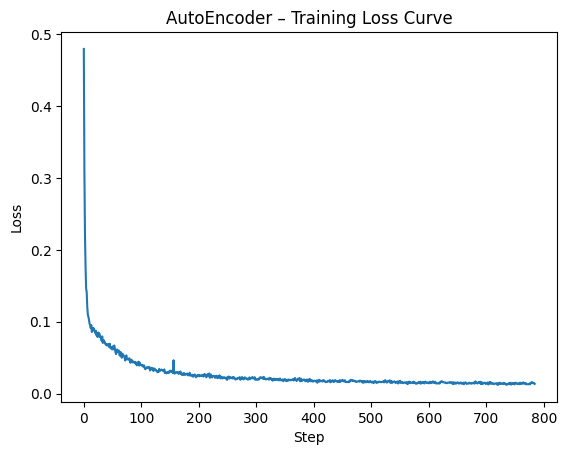

In [ ]:
plt.plot(losses)
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("AutoEncoder – Training Loss Curve")
plt.show()

In [ ]:
eval_bs = 16
eval_dataloader = DataLoader(mnist["test"]["image"], batch_size=eval_bs)

In [ ]:
model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = model(eval_batch.to(device)).cpu()

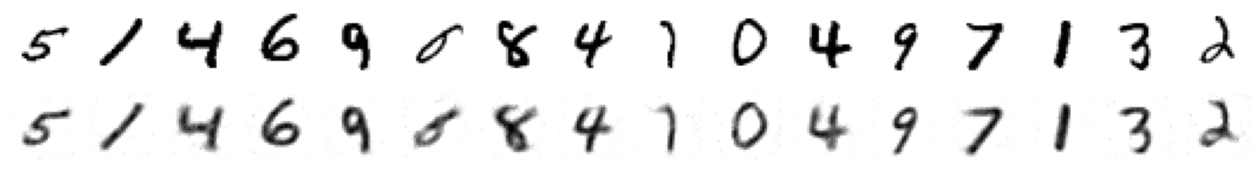

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### Exploring the Latent Space


In [ ]:
ae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted = ae_model(eval_batch.to(device)).cpu()

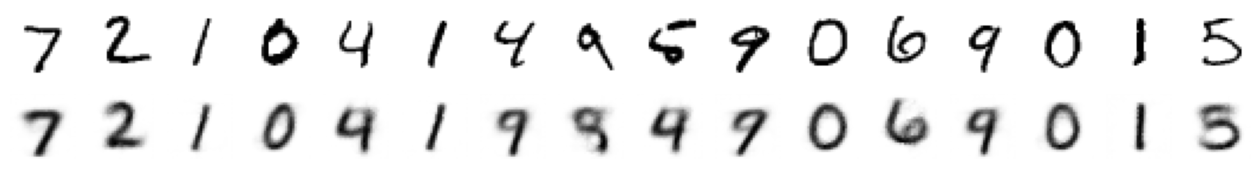

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

### Visualizing the Latent Space


In [ ]:
N = 4 # We'll generate 16 points
z = torch.rand((N, 16)) * 8 - 4

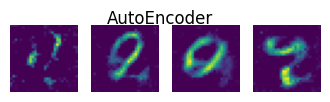

In [ ]:
mpl.rcParams["image.cmap"] = "viridis"
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")

## Variational AutoEncoders (VAEs)

### VAE Encoders and Decoders


In [ ]:
class VAEEncoder(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()

        self.conv_layers = nn.Sequential(
            conv_block(in_channels, 128),
            conv_block(128, 256),
            conv_block(256, 512),
            conv_block(512, 1024),
        )

        # Define fully connected layers for mean and log-variance
        self.mu = nn.Linear(1024, latent_dims)
        self.logvar = nn.Linear(1024, latent_dims)

    def forward(self, x):
        bs = x.shape[0]
        x = self.conv_layers(x)
        x = x.reshape(bs, -1)
        mu = self.mu(x)
        logvar = self.logvar(x)
        return (mu, logvar)

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dims):
        super().__init__()
        self.encoder = VAEEncoder(in_channels, latent_dims)
        self.decoder = Decoder(in_channels)

    def encode(self, x):
        # Returns mu, log_var
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        # Obtain parameters of the normal (Gaussian) distribution
        mu, logvar = self.encode(x)

        # Sample from the distribution
        std = torch.exp(0.5 * logvar)
        z = self.sample(mu, std)

        # Decode the latent point to pixel space
        reconstructed = self.decode(z)

        # Return the reconstructed image, and also the mu and logvar
        # so we can compute a distribution loss
        return reconstructed, mu, logvar

    def sample(self, mu, std):
        # Reparametrization trick
        # Sample from N(0, I), translate and scale
        eps = torch.randn_like(std)
        return mu + eps * std

### Training the VAE


In [ ]:
def vae_loss(batch, reconstructed, mu, logvar):
    bs = batch.shape[0]

    # Reconstruction loss from the pixels - 1 per image
    reconstruction_loss = F.mse_loss(
        reconstructed.reshape(bs, -1),
        batch.reshape(bs, -1),
        reduction="none",
    ).sum(dim=-1)

    # KL-divergence loss, per input image
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=-1)

    # Combine both losses and get the mean across images
    loss = (reconstruction_loss + kl_loss).mean(dim=0)

    return (loss, reconstruction_loss, kl_loss)

In [ ]:
def train_vae(model, num_epochs=10, lr=1e-4):
    model = model.to(device)
    losses = {
        "loss": [],
        "reconstruction_loss": [],
        "kl_loss": [],
    }

    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-5)
    for _ in (progress := trange(num_epochs, desc="Training")):
        for _, batch in (
            inner := tqdm(
                enumerate(train_dataloader), total=len(train_dataloader)
            )
        ):
            batch = batch.to(device)

            # Pass through the model
            reconstructed, mu, logvar = model(batch)

            # Compute the losses
            loss, reconstruction_loss, kl_loss = vae_loss(
                batch, reconstructed, mu, logvar
            )

            # Display loss and store for plotting
            inner.set_postfix(loss=f"{loss.cpu().item():.3f}")
            losses["loss"].append(loss.item())
            losses["reconstruction_loss"].append(
                reconstruction_loss.mean().item()
            )
            losses["kl_loss"].append(kl_loss.mean().item())

            # Update model parameters based on the total loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        progress.set_postfix(loss=f"{loss.cpu().item():.3f}", lr=f"{lr:.0e}")
    return losses

In [ ]:
vae_model = VAE(in_channels=1, latent_dims=16)

In [ ]:
losses = train_vae(vae_model, num_epochs=5, lr=1e-4)

Training:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

  0%|          | 0/157 [00:00<?, ?it/s]

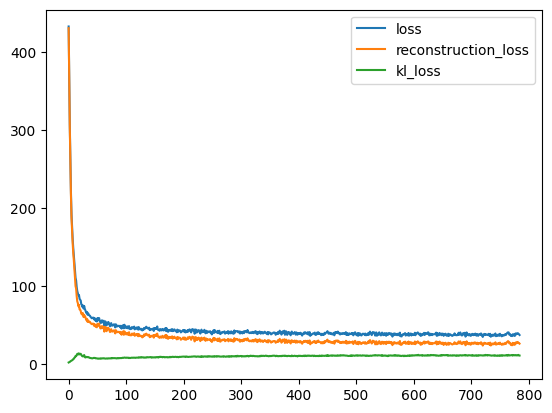

In [ ]:
for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend();

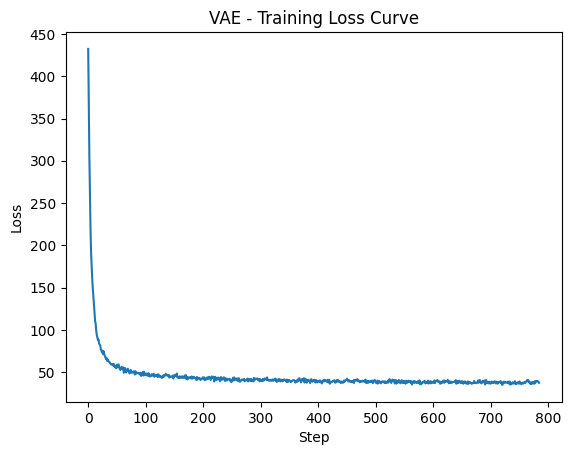

In [ ]:
plt.plot(losses["loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE - Training Loss Curve")
plt.show()

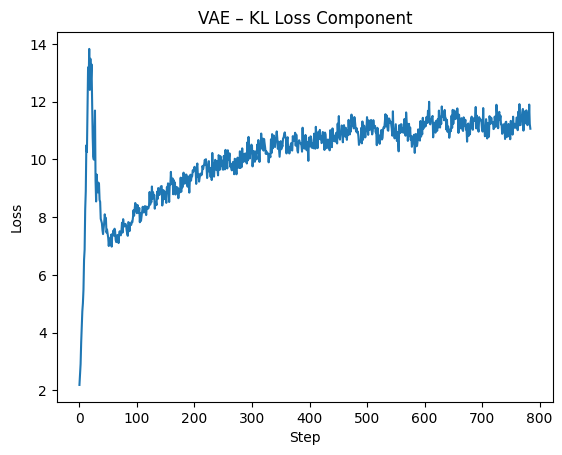

In [ ]:
plt.plot(losses["kl_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – KL Loss Component")
plt.show()

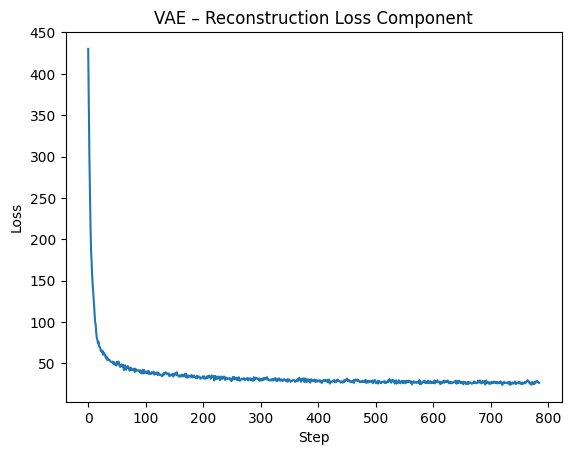

In [ ]:
plt.plot(losses["reconstruction_loss"])
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("VAE – Reconstruction Loss Component")
plt.show()

In [ ]:
vae_model.eval()
with torch.inference_mode():
    eval_batch = next(iter(eval_dataloader))
    predicted, mu, logvar = (v.cpu() for v in vae_model(eval_batch.to(device)))

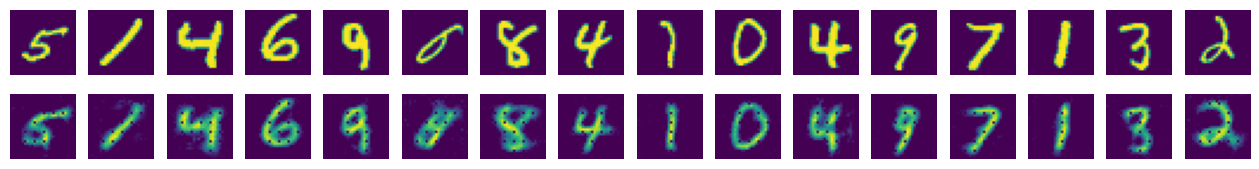

In [ ]:
batch_vs_preds = torch.cat((eval_batch, predicted))
show_images(batch_vs_preds, imsize=1, nrows=2)

In [ ]:
z = torch.normal(0, 1, size=(4, 16))
ae_decoded = model.decode(z.to(device))
vae_decoded = vae_model.decode(z.to(device))

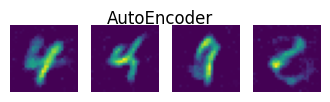

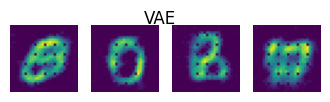

In [ ]:
mpl.rcParams["image.cmap"] = "viridis"
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")
show_images(vae_decoded.cpu(), imsize=1, nrows=1, suptitle="VAE")

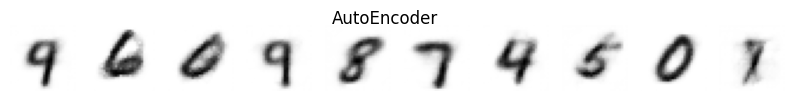

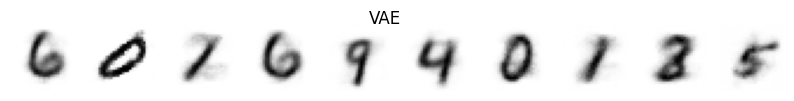

In [ ]:
show_images(ae_decoded.cpu(), imsize=1, nrows=1, suptitle="AutoEncoder")
show_images(vae_decoded.cpu(), imsize=1, nrows=1, suptitle="VAE")

In [8]:
import datasets
import diffusers
import huggingface_hub

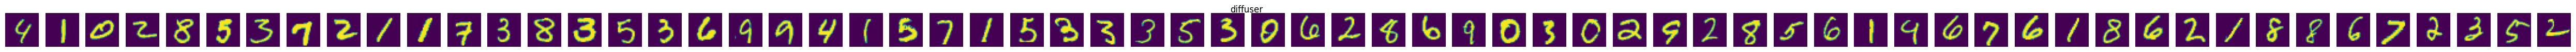

In [11]:
batch = next(iter(train_dataloader))

# When we normalized, we mapped (0, 1) to (-1, 1)
# Now we map back to (0, 1) for display
#show_images(batch["images"][:8] * 0.5 + 0.5)
show_images(batch.cpu(), imsize=1, nrows=1, suptitle="diffuser")

In [12]:
print(type(batch))
batch.shape

<class 'torch.Tensor'>


torch.Size([64, 1, 28, 28])

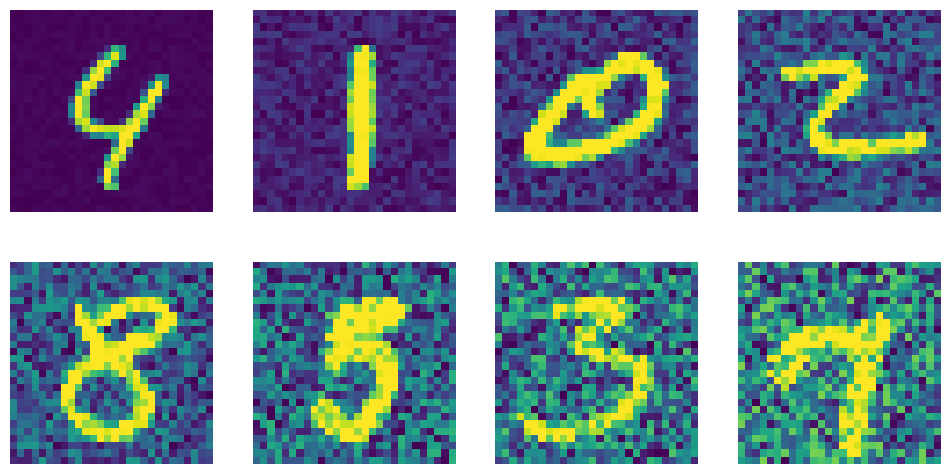

In [13]:
from diffusers import DDPMScheduler

# We'll learn about beta_start and beta_end in the next sections
scheduler = DDPMScheduler(
    num_train_timesteps=100, beta_start=0.001, beta_end=0.02
)

# Create a tensor with 8 evenly spaced values
# from 0 to 999
timesteps = torch.linspace(0, 99, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
x = batch[:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)
show_images((noised_x * 0.5 + 0.5).clip(0, 1))


In [14]:
print(noised_x.shape)
print(x.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


torch.Size([8, 1, 28, 28])
torch.Size([8, 1, 28, 28])


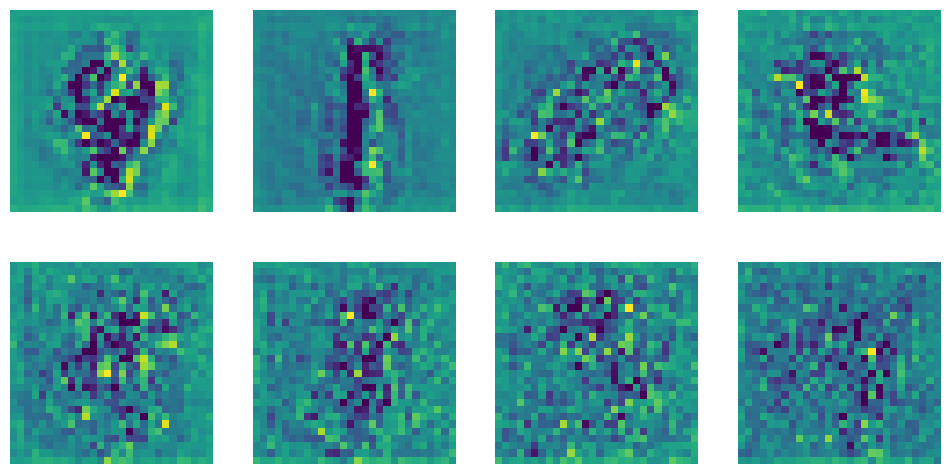

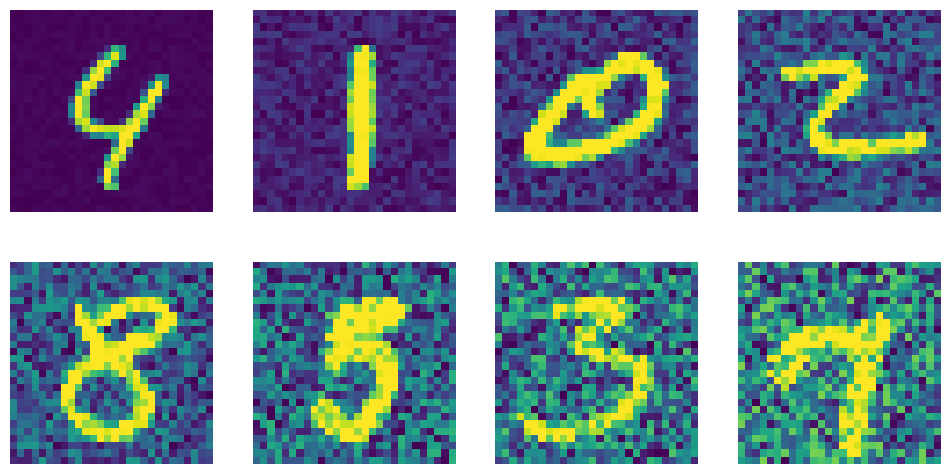

In [20]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,
    out_channels=1,# 3 channels for RGB images
    sample_size=28,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(64, 128),
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D"
    ),
    up_block_types=("AttnUpBlock2D", "UpBlock2D"),
).to(device)

# Pass a batch of data through to make sure it works
with torch.inference_mode():
    out = model(noised_x.to(device), timestep=timesteps.to(device)).sample

print(noised_x.shape)
print(out.shape)
show_images((out * 0.5 + 0.5).clip(0, 1))
show_images((noised_x * 0.5 + 0.5).clip(0, 1))

In [21]:
from torch.nn import functional as F

num_epochs = 10  # How many runs through the data should we do?
lr = 1e-4  # What learning rate should we use
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model (this takes a while)
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["image"].to(device)

        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(device)

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (clean_images.shape[0],),
            device=device,
        ).long()

        # Add noise to the clean images according
        # to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        # The model also uses the timestep as an input
        # for additional conditioning
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise
        loss = F.mse_loss(noise_pred, noise)

        # Store the loss for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


    # Print out the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

/tmp/ipython-input-3293831994.py:12: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  clean_images = batch["image"].to(device)


IndexError: too many indices for tensor of dimension 4

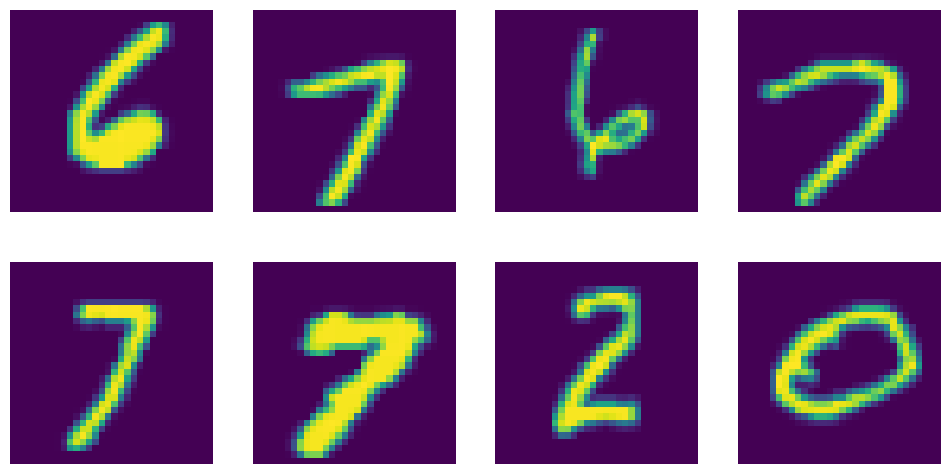

In [26]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

image_size = 32
batch_size = 8


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


mnist.set_transform(transform)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    mnist["train"], batch_size=batch_size, shuffle=True
)
mnist
imgs = next(iter(train_dataloader))["images"]
show_images(imgs)

In [25]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

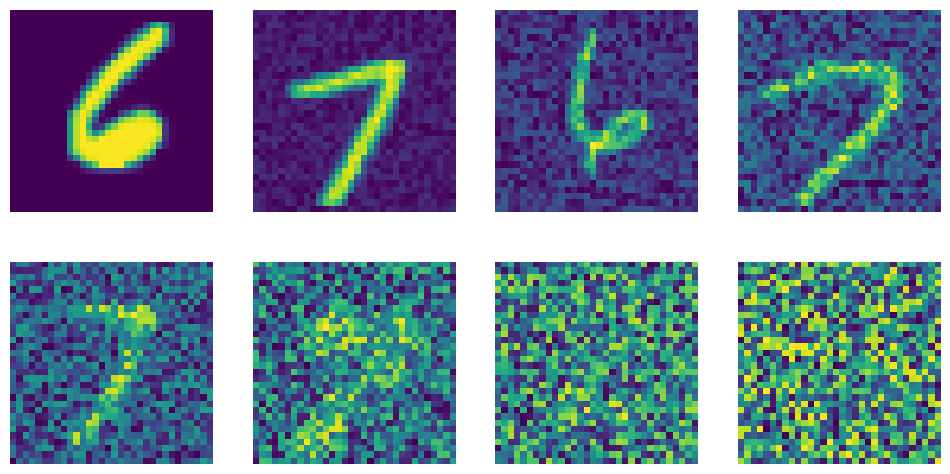

In [28]:
# Adding noise (we go from little corruption to a lot)
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

show_images(noised_x)

In [30]:
from torch import nn


class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # Use the SiLU activation function, which has been shown to work well
        # due to different properties (smoothness, non-monotonicity, etc.).
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))

        return x

In [31]:
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
net(x).shape

torch.Size([8, 1, 32, 32])

In [ ]:
from torch.nn import functional as F

device = get_device()
num_epochs = 5  # How many runs through the data should we do?
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    mnist["train"], batch_size=batch_size, shuffle=True
)

model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        # In the chapter, we use the noise scheduler to manage this
        # as we can pass the timestep. Here, we keep it simple and
        # just sample a random amount of noise to add to the images.
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction
        pred = model(noisy_x)

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.035990
Finished epoch 1. Average loss for this epoch: 0.017003
Finished epoch 2. Average loss for this epoch: 0.013332
